In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from dalex.explainer import Explainer

In [4]:

file = "mushrooms.csv"
df = pd.read_csv(file)

## Edibility label encoding scheme
* 1 is equivalent to a poisonous mushroom
* 0 is equivalent to an edible mushroom

In [5]:
labels = [(1.0 if cls == 'p' else 0.0) for cls in df['class']] 
df_wo_class = df.drop(['class'], axis=1)

In [6]:
df_wo_class_numeric = df_wo_class.copy()
for col in df_wo_class.columns:
    for k in range(len(df_wo_class[col])):
        df_wo_class_numeric[col][k] = ord(df_wo_class[col][k])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
df_wo_class_one_hot = enc.fit_transform(df_wo_class_numeric)

In [10]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
    train_test_split(df_wo_class_numeric, labels, test_size = 0.3, random_state = 314159265)

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=16,
    max_depth=7
    )
rf_model.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=16,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

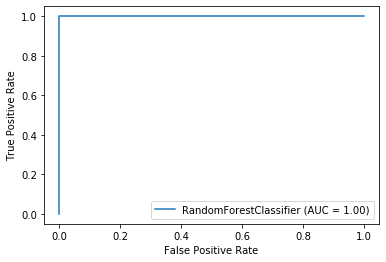

In [79]:
roc_value = plot_roc_curve(rf_model, test_features, test_labels)
plt.show()

In [68]:
rf_explainer = Explainer(
    model=rf_model,
    data=df_wo_class_numeric,
    y=np.array(labels),
    model_type='classification'
    )

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 8124 rows 22 cols
  -> target variable   : 8124 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x000002E44AD209D0> will be used
  -> predicted values  : min = 0.0, mean = 0.48217459060450435, max = 1.0
  -> residual function : difference between y and yhat
  -> residuals         : min = -0.2491178922175317, mean = -0.00014603324359837251, max = 0.5996980919349062
  -> model_info        : package sklearn

A new explainer has been created!


In [89]:
def draw_breakdown(explainer, mushroom):
    breakdown = explainer.predict_parts(mushroom, type='break_down')    
    breakdown.plot(max_vars=60)

In [138]:
def draw_breakdown_from_id(explainer, mushroom_id):
    draw_breakdown(explainer, df_wo_class_numeric.iloc[mushroom_id, :])

## Task 5 explained

### Task 2 and 3: 

In [140]:
draw_breakdown_from_id(rf_explainer, 20)

The random forest is almost certain about the mushroom's (no 20) edibility.

In [148]:
draw_breakdown_from_id(rf_explainer, 950)

In [152]:
chr(df_wo_class_numeric.iloc[20, :]['gill-size'])

'b'

In [151]:
chr(df_wo_class_numeric.iloc[950, :]['gill-size'])

'n'

In [168]:
poisonous = 0
count = 0
gill_size_feature = df_wo_class_numeric.iloc[950,:]['gill-size']
for instance, label in zip(df_wo_class_numeric.iloc, labels):
    if instance['gill-size'] == gill_size_feature:
        count += 1
        poisonous += 1 if label == 1.0 else 0
print(poisonous / count)

0.8853503184713376


For mushroom no 20 its broad gill size speaks for its edibility, whereas for model no 950 its narrow gill indicates its toxicity. Baseline prediction would agree that narrow lamella indicates poisonous mushroom (correct for 89% of instances). Broad lamella, in general, hints edibility (70%) but more features are needed to make an informed decision.

## Task 4 explained

In [169]:
draw_breakdown_from_id(rf_explainer, 100)

The most influential feature for mushroom no 950 is the narrow gill-size and existence of bruises, whereas for mushroom no 100 the most impactful feature is its lack of odor, wide gill-spacing, the colour of its black spore prints and its fibrous stalk surface above ring.

In [74]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors=10,
    leaf_size=10
    )
knn_model.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [80]:
knn_explainer = Explainer(
    model=knn_model,
    data=df_wo_class_numeric,
    y=np.array(labels),
    model_type='classification'
    )

Preparation of a new explainer is initiated

  -> label             : not specified, model's class taken instead!
  -> data              : 8124 rows 22 cols
  -> target variable   : 8124 values
  -> predict function  : <function yhat.<locals>.<lambda> at 0x000002E4482D7AF0> will be used
  -> predicted values  : min = 0.0, mean = 0.4801575578532743, max = 1.0
  -> residual function : difference between y and yhat
  -> residuals         : min = -0.5, mean = 0.0018709995076317085, max = 0.7
  -> model_info        : package sklearn

A new explainer has been created!


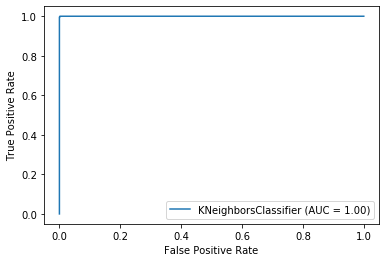

In [81]:
roc_value = plot_roc_curve(knn_model, test_features, test_labels)
plt.show()

##  Task 6 explained

In [105]:
draw_breakdown(rf_explainer, test_features.iloc[2,:])

In [106]:
draw_breakdown(knn_explainer, test_features.iloc[2,:])

In [133]:
chr(test_features.iloc[2,:]['stalk-root'])

'?'

* Random forest model univocally predicted toxicity of the mushroom. Persistently, almost all features indicated that the mushroom is poisonous. The colour of the stalk does not influence the result. It makes perfectly makes sense, as it is unknown.
* In the case of the K nearest neighbour classifier more features spoke for edibility of the mushroom. Nevertheless, the lack of stalk root colour overwhelimngly determined its poisonousness. All other features combined did not clarify whether the fungus is edible.

In [134]:
test_labels[2]

1.0

Indeed, the mushroom is poisonous.

In [135]:
poisonous = 0
count = 0
stalk_root_feature = test_features.iloc[2,:]['stalk-root']
for instance, label in zip(df_wo_class_numeric.iloc, labels):
    if instance['stalk-root'] == stalk_root_feature:
        count += 1
        poisonous += 1 if label == 1.0 else 0
print(poisonous / count)

0.7096774193548387


In general, about 71% of fungi are poisonous when we cannot determine the colour of the stalk. The predictions actually made sense.